In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [48]:
df = pd.read_csv("data/survey_results_public.csv")

In [49]:
print(df.shape)

(88883, 85)


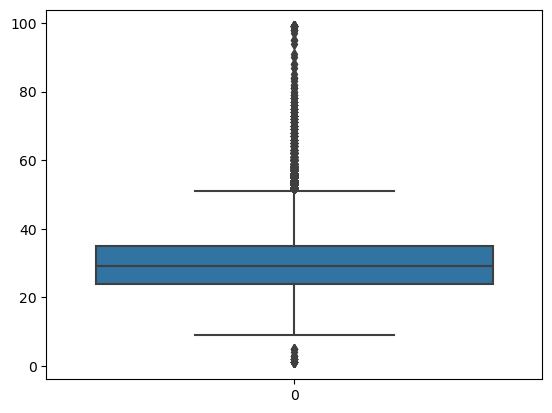

In [50]:
x=df["Age"]
sns.boxplot(x)
plt.show()

In [51]:
q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr
# print(df[(df["Age"] < low) | (df["Age"] > up)])

In [52]:
print(df[(df["Age"] < low) | (df["Age"] > up)].index)

Index([   44,   107,   110,   133,   191,   212,   220,   373,   390,   429,
       ...
       88709, 88724, 88739, 88779, 88811, 88818, 88828, 88850, 88865, 88870],
      dtype='int64', length=2691)


In [53]:
print(df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None))

True


In [54]:
print(df[(df["Age"] < low)].any(axis=None))

True


In [55]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

print(outlier_thresholds(df, "Age"))

(7.5, 51.5)


In [56]:
low, up = outlier_thresholds(df, "WorkWeekHrs")
print(df[(df["WorkWeekHrs"] < low) | (df["WorkWeekHrs"] > up)].head())

   Respondent                                         MainBranch Hobbyist  \
3           4                     I am a developer by profession       No   
4           5                     I am a developer by profession      Yes   
5           6  I am not primarily a developer, but I write co...      Yes   
6           7                     I am a developer by profession       No   
8           9                     I am a developer by profession      Yes   

                  OpenSourcer  \
3                       Never   
4  Once a month or more often   
5                       Never   
6                       Never   
8  Once a month or more often   

                                          OpenSource  \
3  The quality of OSS and closed source software ...   
4  OSS is, on average, of HIGHER quality than pro...   
5  The quality of OSS and closed source software ...   
6  The quality of OSS and closed source software ...   
8  The quality of OSS and closed source software ...   

 

In [57]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

print(check_outlier(df, "Age"))
print(check_outlier(df, "WorkWeekHrs"))

True
True


In [58]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car
    
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 88883
Variables: 85
cat_cols: 54
num_cols: 6
cat_but_car: 25
num_but_cat: 0


In [59]:
num_cols = [col for col in num_cols if col not in "PassengerId"]
print(num_cols)  

for col in num_cols:
    print(col, check_outlier(df, col))

['Respondent', 'CompTotal', 'ConvertedComp', 'WorkWeekHrs', 'CodeRevHrs', 'Age']
Respondent False
CompTotal True
ConvertedComp True
WorkWeekHrs True
CodeRevHrs True
Age True


In [60]:
def grab_outliers(dataframe, col_name, outlier_index=False, f = 5):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head(f))
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if outlier_index:
        out_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return out_index
age_index = grab_outliers(df, "Age", True)

     Respondent                                         MainBranch Hobbyist  \
44           45  I am not primarily a developer, but I write co...      Yes   
107         108                     I am a developer by profession      Yes   
110         111                     I am a developer by profession      Yes   
133         134  I am not primarily a developer, but I write co...      Yes   
191         193                     I am a developer by profession       No   

                 OpenSourcer  \
44                     Never   
107  Less than once per year   
110                    Never   
133  Less than once per year   
191                    Never   

                                            OpenSource  \
44   The quality of OSS and closed source software ...   
107  OSS is, on average, of HIGHER quality than pro...   
110  The quality of OSS and closed source software ...   
133  OSS is, on average, of LOWER quality than prop...   
191  The quality of OSS and closed source 

In [61]:
print(age_index)

Index([   44,   107,   110,   133,   191,   212,   220,   373,   390,   429,
       ...
       88709, 88724, 88739, 88779, 88811, 88818, 88828, 88850, 88865, 88870],
      dtype='int64', length=2691)


In [62]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers




cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 88883
Variables: 85
cat_cols: 54
num_cols: 6
cat_but_car: 25
num_but_cat: 0


In [63]:
num_cols.remove('CodeRevHrs')

for col in num_cols:
    df = remove_outlier(df,col)

In [64]:
print(df.shape)

(60896, 85)


In [68]:
df["variable"] = ""
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [69]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [70]:
for col in num_cols:
    print(col, check_outlier(df, col))

Respondent False
CompTotal False
ConvertedComp False
WorkWeekHrs False
Age False
